Load & Filter the Dataset

In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("/content/LungCanC2024_Dataset.csv")

# Focus only on lung cancer patients
cancer = df[df["cancer_presence"] == 1].copy()

cancer.head()

,nodule_size_mm,nodule_texture,HU_mean,HU_std,GLCM_contrast,GLCM_correlation,PET_SUVmax,PET_SUVmean,patient_age,patient_gender,...,targeted_therapy_received,EGFR_mutation_status,KRAS_mutation_status,ALK_fusion_status,PD-L1_expression_level,tumor_mutational_burden,cancer_presence,cancer_subtype,cancer_stage,survival_time_months
0,3.754145,0.779723,-719.889488,160.069061,11.093420,0.877811,0.964536,1.896542,85,Male,...,0,0,1,0,42.178630,0.413221,1,No Cancer,Stage II,23.916617
1,24.080971,0.873834,-259.176808,122.088962,2.739776,0.610637,12.441004,0.501087,81,Male,...,0,1,1,0,97.468371,0.763461,1,Squamous Cell,Stage III,11.859306
3,7.303540,0.826359,-249.694708,242.576964,2.941016,0.507490,2.817405,2.744690,85,Male,...,0,0,0,1,28.871351,1.288862,1,No Cancer,No Cancer,37.703014
4,1.356999,0.490455,-697.653568,44.987641,4.093630,0.543351,0.396519,2.753422,38,Male,...,0,0,0,0,64.792249,6.477791,1,Squamous Cell,No Cancer,2.828828
5,1.356770,0.362565,-1.953923,28.551171,5.009500,0.626415,2.557224,1.424201,31,Female,...,0,1,0,0,68.425534,4.769339,1,Adenocarcinoma,No Cancer,31.250921


Create Treatment Burden Index

In [2]:
# Define therapy weights (clinical reasoning)
weights = {
    "chemotherapy_received": 2,
    "radiation_therapy": 1,
    "immunotherapy_received": 2,
    "targeted_therapy_received": 2
}

# Weighted treatment burden score
cancer["treatment_burden"] = sum(
    cancer[col] * weight for col, weight in weights.items()
)

# Simple therapy count
cancer["therapy_count"] = cancer[list(weights.keys())].sum(axis=1)

cancer[["treatment_burden", "therapy_count"]].describe()


,treatment_burden,therapy_count
count,187913.000000,187913.000000
mean,1.954213,1.151794
std,1.538697,0.872985
min,0.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,1.000000
75%,3.000000,2.000000
max,7.000000,4.000000


Build Tumor Aggressiveness Score

In [3]:
# Aggressiveness-related features
aggr_features = [
    "nodule_size_mm",
    "PET_SUVmax",
    "tumor_mutational_burden",
    "PD-L1_expression_level"
]

# Convert to numeric and handle missing values
cancer[aggr_features] = cancer[aggr_features].apply(
    pd.to_numeric, errors="coerce"
)
cancer[aggr_features] = cancer[aggr_features].fillna(
    cancer[aggr_features].median()
)

# Z-score normalization
for col in aggr_features:
    cancer[col + "_z"] = (
        (cancer[col] - cancer[col].mean()) / cancer[col].std(ddof=0)
    )

# Combined aggressiveness score
cancer["aggressiveness_score"] = cancer[
    [col + "_z" for col in aggr_features]
].mean(axis=1)

cancer["aggressiveness_score"].describe()


,aggressiveness_score
count,1.879130e+05
mean,-1.445376e-16
std,5.005429e-01
min,-1.168121e+00
25%,-3.545064e-01
50%,-5.360528e-02
75%,2.898972e-01
max,3.433484e+00


Define Pre-Escalation Risk Flag

In [4]:
# Thresholds (top 25%)
burden_threshold = cancer["treatment_burden"].quantile(0.75)
aggr_threshold = cancer["aggressiveness_score"].quantile(0.75)

# Binary flags
cancer["high_burden"] = (
    cancer["treatment_burden"] >= burden_threshold
).astype(int)

cancer["high_aggressiveness"] = (
    cancer["aggressiveness_score"] >= aggr_threshold
).astype(int)

cancer["advanced_stage"] = cancer["tumor_stage"].isin(
    ["Stage III", "Stage IV"]
).astype(int)

# Final actionable early-warning flag
cancer["pre_escalation_risk"] = (
    (cancer["high_burden"] == 1) &
    (
        (cancer["high_aggressiveness"] == 1) |
        (cancer["advanced_stage"] == 1)
    )
).astype(int)

cancer["pre_escalation_risk"].value_counts()


,count
pre_escalation_risk,
0,140662
1,47251


Summarize Results

In [5]:
summary = cancer.groupby("pre_escalation_risk").agg(
    patients=("pre_escalation_risk", "count"),
    avg_treatment_burden=("treatment_burden", "mean"),
    avg_therapy_count=("therapy_count", "mean"),
    chemo_rate=("chemotherapy_received", "mean"),
    immuno_rate=("immunotherapy_received", "mean"),
    targeted_rate=("targeted_therapy_received", "mean"),
    radiation_rate=("radiation_therapy", "mean"),
    advanced_stage_rate=("advanced_stage", "mean"),
    avg_PET_SUVmax=("PET_SUVmax", "mean"),
    avg_nodule_size=("nodule_size_mm", "mean"),
    avg_TMB=("tumor_mutational_burden", "mean")
).round(3)

summary


,patients,avg_treatment_burden,avg_therapy_count,chemo_rate,immuno_rate,targeted_rate,radiation_rate,advanced_stage_rate,avg_PET_SUVmax,avg_nodule_size,avg_TMB
pre_escalation_risk,,,,,,,,,,,
0,140662,1.350,0.794,0.341,0.124,0.090,0.239,0.633,3.918,7.836,4.890
1,47251,3.754,2.216,0.775,0.432,0.332,0.678,0.903,4.272,8.562,5.307


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# ----summary numbers (from Step 5 output) ----
summary = pd.DataFrame({
    "pre_escalation_risk": [0, 1],
    "patients": [140662, 47251],
    "avg_treatment_burden": [1.350, 3.754],
    "avg_therapy_count": [0.794, 2.216],
    "chemo_rate": [0.341, 0.775],
    "immuno_rate": [0.124, 0.432],
    "targeted_rate": [0.090, 0.332],
    "radiation_rate": [0.239, 0.678],
    "advanced_stage_rate": [0.633, 0.903],
    "avg_PET_SUVmax": [3.918, 4.272],
    "avg_nodule_size": [7.836, 8.562],
    "avg_TMB": [4.890, 5.307]
})

summary["risk_label"] = summary["pre_escalation_risk"].map({0: "Low Risk", 1: "High Risk"})
summary


,pre_escalation_risk,patients,avg_treatment_burden,avg_therapy_count,chemo_rate,immuno_rate,targeted_rate,radiation_rate,advanced_stage_rate,avg_PET_SUVmax,avg_nodule_size,avg_TMB,risk_label
0,0,140662,1.350,0.794,0.341,0.124,0.090,0.239,0.633,3.918,7.836,4.890,Low Risk
1,1,47251,3.754,2.216,0.775,0.432,0.332,0.678,0.903,4.272,8.562,5.307,High Risk


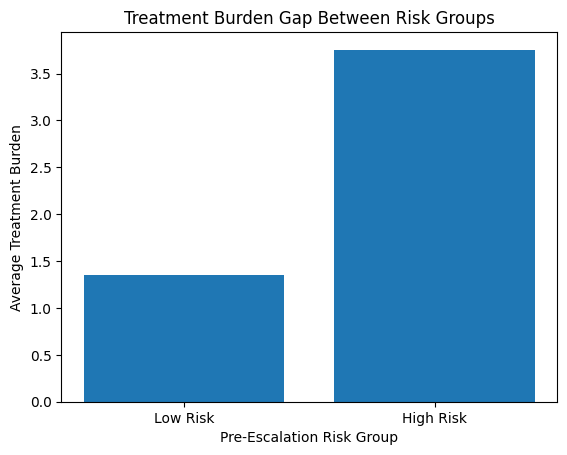

In [7]:
# ---- Graph 1: Treatment Burden Gap (Bar Chart) ----
plt.figure()
plt.bar(summary["risk_label"], summary["avg_treatment_burden"])
plt.xlabel("Pre-Escalation Risk Group")
plt.ylabel("Average Treatment Burden")
plt.title("Treatment Burden Gap Between Risk Groups")
plt.show()


*Low-risk patients have an average treatment burden of ~1.35

*High-risk patients have an average treatment burden of ~3.75

*This indicates nearly a three-fold increase in treatment intensity

Interpretation:
This graph highlights a substantial difference in treatment intensity between low- and high-risk patients. Although individual therapies were recorded in the dataset, the overall treatment burden was not explicitly quantified. By constructing a Treatment Burden Index, this visualization reveals a clinically meaningful escalation pattern that was previously hidden in the raw data.

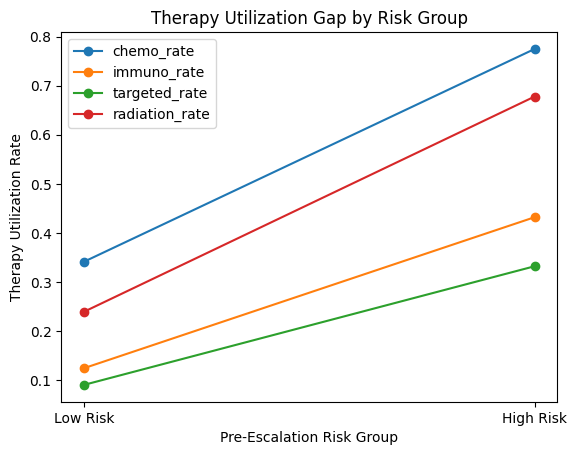

In [8]:
# ---- Graph 2: Therapy Utilization Gap (Line Chart) ----
therapy_cols = ["chemo_rate", "immuno_rate", "targeted_rate", "radiation_rate"]

plt.figure()
for col in therapy_cols:
    plt.plot(summary["risk_label"], summary[col], marker="o", label=col)

plt.xlabel("Pre-Escalation Risk Group")
plt.ylabel("Therapy Utilization Rate")
plt.title("Therapy Utilization Gap by Risk Group")
plt.legend()
plt.show()


Across all therapy types, utilization is consistently higher in the high-risk group:
*Chemotherapy: ~34% → ~78%

*Immunotherapy: ~12% → ~43%

*Targeted therapy: ~9% → ~33%

*Radiation therapy: ~24% → ~68%

Interpretation:
This line chart shows that treatment escalation is not driven by a single therapy but occurs systematically across multiple treatment modalities. High-risk patients are more likely to receive combination therapies, indicating higher clinical complexity and greater risk of treatment-related complications.

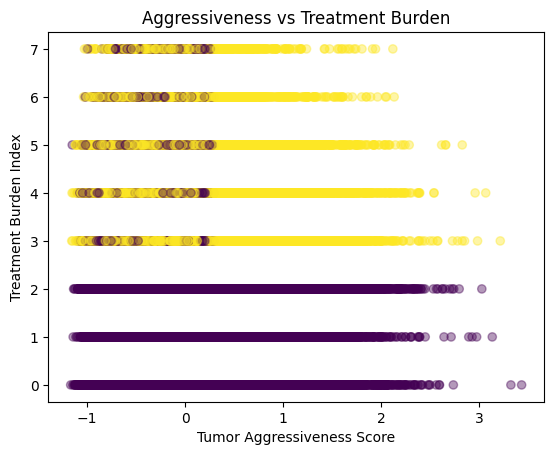

In [9]:
import matplotlib.pyplot as plt

plt.figure()

# Scatter plot
plt.scatter(
    cancer["aggressiveness_score"],
    cancer["treatment_burden"],
    c=cancer["pre_escalation_risk"],
    alpha=0.4
)

plt.xlabel("Tumor Aggressiveness Score")
plt.ylabel("Treatment Burden Index")
plt.title("Aggressiveness vs Treatment Burden")

plt.show()


*Treatment burden increases stepwise as tumor aggressiveness increases

*Low-risk patients cluster in the lower-left (low aggressiveness, low burden)

*High-risk patients cluster in the upper-right (high aggressiveness, high burden)

Interpretation:
This scatter plot demonstrates alignment between tumor biology and treatment intensity. More aggressive tumors tend to receive more intensive therapy. However, without an integrated aggressiveness score and treatment burden index, this relationship is not easily visible in the raw dataset.


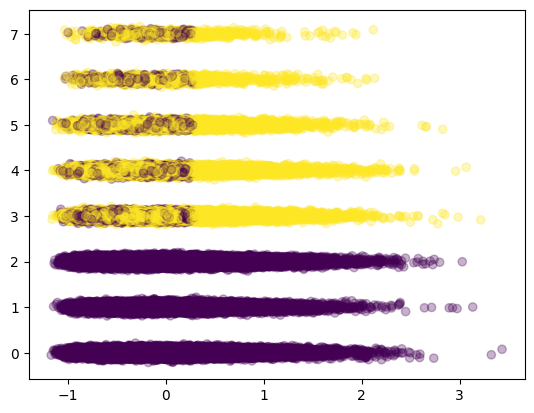

In [10]:
plt.scatter(
    cancer["aggressiveness_score"],
    cancer["treatment_burden"] + np.random.normal(0, 0.05, size=len(cancer)),
    c=cancer["pre_escalation_risk"],
    alpha=0.3
)


*The same relationship as Graph 3, but with reduced overlap

*High-risk patients are more clearly concentrated at higher treatment burden levels

*Low-risk patients remain clustered at lower burden levels

Interpretation:
Adding jitter reduces visual overlap and makes patient-level distributions clearer. This visualization reinforces that the pre-escalation risk flag separates patients into clinically distinct groups based on both biological aggressiveness and treatment intensity.